In [1]:
import pandas as pd
goalkeeper_data_df = pd.read_csv('/kaggle/input/combined-data/goalkeeper_data.csv')
outfield_data_df = pd.read_csv('/kaggle/input/combined-data/outfield_data.csv')

# Splitting the dataset
First we split the dataset (outfield players and goalkeepers) into training and test data.
* Note the imbalance of dataset because it is expected that only a handful of players get injured during the course of the season.
* We want to transform categorical features such as 'League', 'Position' and 'Categorized Position' into numerical values to feed into the model using One Hot Encoding
* Target variables are 'Total Days', 'Total Games Missed', 'Injury Count', 'Average Injury Cost', 'Injury Rate'; the things we would want to predict

In [2]:
from sklearn.preprocessing import OneHotEncoder

def one_hot_encoding(df, cols):
    # Create a OneHotEncoder object
    encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

    # Fit and transform the 'Position' column
    df_encoded = pd.DataFrame(encoder.fit_transform(df[cols]))
    df_encoded.columns = encoder.get_feature_names_out()

    df.drop(cols, axis=1, inplace=True)
    return pd.concat([df, df_encoded], axis = 1)

outfield_cols = ['Position', 'Categorized Position', 'League']
gk_cols = ['League']
outfield_data_df = one_hot_encoding(outfield_data_df, outfield_cols)
goalkeeper_data_df = one_hot_encoding(goalkeeper_data_df, gk_cols)

In [3]:
from sklearn.model_selection import train_test_split

# Select features (X) and target variable (y)
outfield_X = outfield_data_df.drop(['Total Days', 'Total Games Missed', 'Injury Count', 'Average Injury Cost', 'Injury Rate', 'Name', 'Birthday', 'Club', 'Injuries', 'Type of Injury', 'Categorized Injuries'], axis=1)
outfield_y = outfield_data_df[['Total Days', 'Total Games Missed', 'Injury Count', 'Average Injury Cost', 'Injury Rate']]
goalkeeper_X = goalkeeper_data_df.drop(['Position', 'Categorized Position', 'Total Days', 'Total Games Missed', 'Injury Count', 'Average Injury Cost', 'Injury Rate', 'Name', 'Birthday', 'Club', 'Injuries', 'Type of Injury', 'Categorized Injuries'], axis=1)
goalkeeper_y = goalkeeper_data_df[['Total Days', 'Total Games Missed', 'Injury Count', 'Average Injury Cost', 'Injury Rate']]

# Split the data into training and testing sets
outfield_X_train, outfield_X_test, outfield_y_train, outfield_y_test = train_test_split(outfield_X, outfield_y, test_size=0.2, random_state=42)
goalkeeper_X_train, goalkeeper_X_test, goalkeeper_y_train, goalkeeper_y_test = train_test_split(goalkeeper_X, goalkeeper_y, test_size=0.2, random_state=42)

In [4]:
# Export datasets
outfield_X_train.to_csv('outfield_X_train.csv', index=False)
outfield_X_test.to_csv('outfield_X_test.csv', index=False)
outfield_y_train.to_csv('outfield_y_train.csv', index=False)
outfield_y_test.to_csv('outfield_y_test.csv', index=False)
goalkeeper_X_train.to_csv('goalkeeper_X_train.csv', index=False)
goalkeeper_X_test.to_csv('goalkeeper_X_test.csv', index=False)
goalkeeper_y_train.to_csv('goalkeeper_y_train.csv', index=False)
goalkeeper_y_test.to_csv('goalkeeper_y_test.csv', index=False)

from sklearn.preprocessing import StandardScaler, MaxAbsScaler, MinMaxScaler, RobustScaler

# Perform standardisaion
scaler = MinMaxScaler()
outfield_X_train = scaler.fit_transform(outfield_X_train)
outfield_X_test = scaler.fit_transform(outfield_X_test)

goalkeeper_X_train = scaler.fit_transform(goalkeeper_X_train)
goalkeeper_X_test = scaler.fit_transform(goalkeeper_X_test)

# Analysis of training data
We want to identify the general behaviour of our training dataset. We can do so by reducing the dimensionality using Principle Component Analysis. This helps us:
* Reduce dimensions of our features
* Identify any linear seperability between targets

## PCA Analysis
PCA essentially creates as many principal components as there are features in our data. These components are arranged in order of importance, indicating how much of the PCA variance of our data is explained by each component. Typically we want to keep about 80% of the variance, and from the result below, the number of components that we should keep is around 12.5 to 15.

[0.17150201 0.12437322 0.10420449 0.07853144 0.07303621 0.05834568
 0.05260792 0.03377087 0.02874655 0.02640965 0.02360597 0.02200985
 0.0209873  0.02011761 0.01834238 0.01742599 0.01428694 0.01318348
 0.01205291 0.01053297]


Text(0, 0.5, 'Cumulative Explained Vairance')

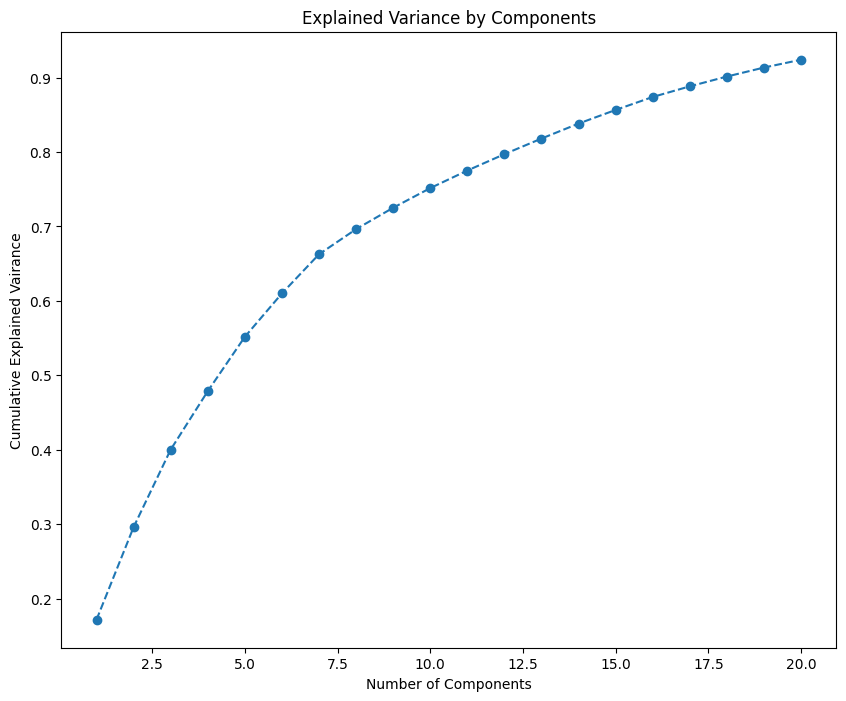

In [5]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA()
pca.fit(outfield_X_train)

explained_variance = pca.explained_variance_ratio_[:20].cumsum()
print(pca.explained_variance_ratio_[:20])

plt.figure(figsize = (10, 8))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker = "o", linestyle = "--")
plt.title("Explained Variance by Components")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Vairance")

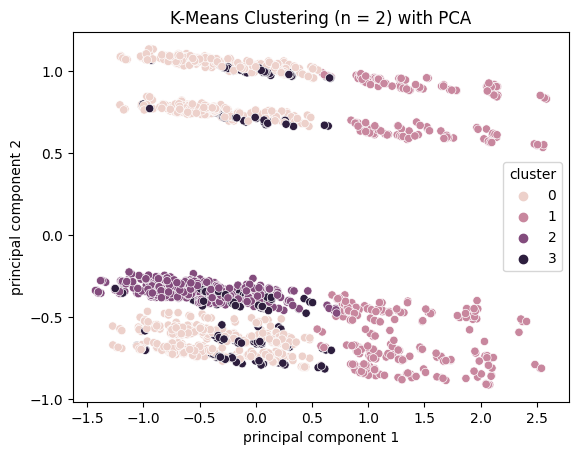

In [6]:
from sklearn.cluster import KMeans
import seaborn as sns

# Apply K-Means clustering (as you did before)
kmeans = KMeans(n_clusters=4, random_state=42, n_init='auto')
cluster_labels = kmeans.fit_predict(outfield_X_train)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
outfield_pca2_X_train = pca.fit_transform(outfield_X_train)
outfield_pca2_X_test = pca.transform(outfield_X_test)
principalDf = pd.DataFrame(data = outfield_pca2_X_train, columns = ['principal component 1', 'principal component 2'])

# Add cluster labels to the principal components DataFrame
principalDf['cluster'] = cluster_labels

# Visualize the clusters using Seaborn
sns.scatterplot(x='principal component 1', y='principal component 2', hue='cluster', data=principalDf)
plt.title('K-Means Clustering (n = 2) with PCA')
plt.show()

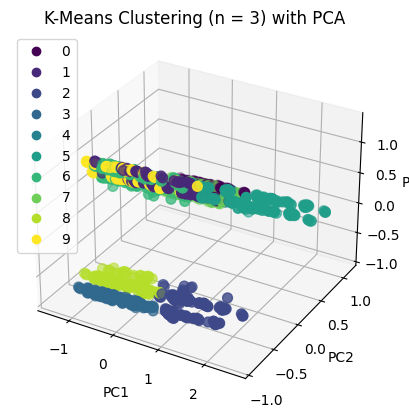

In [7]:
# Apply K-Means clustering (as you did before)
kmeans = KMeans(n_clusters=10, random_state=42, n_init='auto')
cluster_labels = kmeans.fit_predict(outfield_X_train)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=3)
outfield_pca3_X_train = pca.fit_transform(outfield_X_train)
outfield_pca3_X_test = pca.transform(outfield_X_test)
principalDf = pd.DataFrame(data = outfield_pca3_X_train, columns = ['PCA1', 'PCA2', 'PCA3'])

# Add cluster labels to the principal components DataFrame
principalDf['cluster'] = cluster_labels

# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(principalDf['PCA1'], principalDf['PCA2'], principalDf['PCA3'], c=principalDf['cluster'], cmap='viridis', s=50)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

plt.legend(*scatter.legend_elements())
plt.title('K-Means Clustering (n = 3) with PCA')
plt.show()

In [8]:
# Apply PCA for dimensionality reduction
pca = PCA(n_components=13)
outfield_pca13_X_train = pca.fit_transform(outfield_X_train)
outfield_pca13_X_test = pca.transform(outfield_X_test)

# Training Different Regression Models
In the follow sections, we try to train different regression models on our data. To evaluate the performance of each regression mode, we can use several scores
* **Mean Squared Error (MSE)**
    * Formula: `MSE = Σ(y_true - y_pred)^2 / n`
    * Range: 0 to infinity
    * Interpretation: Measures the average squared difference between predicted and actual values. Lower values indicate better performance.
    * Sensitivity: Sensitive to outliers due to squaring the errors.
* **Normalized Root Mean Squared Error (NRMSE)**
    * Formula: `NRMSE = RMSE / Mean(y_true)`
    * Range: 0 to infinity
    * Interpretation: Provides a relative measure of error, making it easier to compare models for different target variables. Lower NRMSE values indicate better model performance.
        * An NRMSE value of 1 indicates that the average prediction error is equal to the average value of the target variable.
        * An NRMSE value less than 1 suggests that the model's predictions are better than simply predicting the mean.
    * Sensitivity: Like MSE, sensitive to outliers.
* **Mean Absolute Error (MAE)**
    * Formula: `MAE = Σ|y_true - y_pred| / n`
    * Range: 0 to infinity
    * Interpretation: Measures the average absolute difference between predicted and actual values. Less sensitive to outliers than MSE.
    * Sensitivity: Less sensitive to outliers compared to MSE.
* **R-squared (Coefficient of Determination)**
    * Formula: `R^2 = 1 - (SS_res / SS_tot)`
    * Range: -infinity to 1
    * Interpretation: Represents the proportion of variance in the dependent variable explained by the independent variables. Higher values indicate a better fit.
    * Negative R-squared: Indicates the model is performing worse than simply predicting the mean of the dependent variable.

In [9]:
evaluation_metrics = {'Model': [], 'Target': [], 'Mean Square Error': [], 'Mean Absolute Error': [], 'Normalized Root Mean Square Error': [], 'R-Squared Error': []}
def add_evaluation_metrics(model, target, mse, mae, nrmse, r2):
    evaluation_metrics['Model'].append(model)
    evaluation_metrics['Target'].append(target)
    evaluation_metrics['Mean Square Error'].append(mse)
    evaluation_metrics['Mean Absolute Error'].append(mae)
    evaluation_metrics['Normalized Root Mean Square Error'].append(nrmse)
    evaluation_metrics['R-Squared Error'].append(r2)

## Simple Linear Regression Model

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from termcolor import colored
import numpy as np

def normalized_root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred)) / np.mean(y_true)

targets = ['Total Days', 'Total Games Missed', 'Injury Count', 'Average Injury Cost', 'Injury Rate']
def get_linear_regression_scores(df_X, df_y, X_test, y_test, target):
    model = LinearRegression()
    model.fit(df_X, df_y[target])

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Calculate the MSE
    mse = mean_squared_error(y_test[target], y_pred)

    print("Mean Squared Error for ", target, ":", mse)
          
    nrmse = normalized_root_mean_squared_error(y_test[target], y_pred)
          
    print("Normalised Root Mean Squared Error for ", target, ":", nrmse)
    
    mae = mean_absolute_error(outfield_y_test['Total Days'], y_pred)
    
    print("Mean Absolute Error for ", target, ":", mae)
          
    # Calculate the R-squared score
    r2 = r2_score(y_test[target], y_pred)

    print("R-squared for ", target, ":", r2, "\n")
    
    return (mse, mae, nrmse, r2)

print(colored('All features:', 'black', attrs=['bold']))
for target in targets:
    mse, mae, nrmse, r2 = get_linear_regression_scores(outfield_X_train, outfield_y_train, outfield_X_test, outfield_y_test, target)
    add_evaluation_metrics('Linear Regression', target, mse, mae, nrmse, r2)

print(colored('PCA Components with n = 2:', 'black', attrs=['bold']))
for target in targets:
    mse, mae, nrmse, r2 = get_linear_regression_scores(outfield_pca2_X_train, outfield_y_train, outfield_pca2_X_test, outfield_y_test, target)
    add_evaluation_metrics('Linear Regression (PCA n = 2)', target, mse, mae, nrmse, r2)
    
print(colored('PCA Components with n = 3:', 'black', attrs=['bold']))
for target in targets:
    mse, mae, nrmse, r2 = get_linear_regression_scores(outfield_pca3_X_train, outfield_y_train, outfield_pca3_X_test, outfield_y_test, target)
    add_evaluation_metrics('Linear Regression (PCA n = 3)', target, mse, mae, nrmse, r2)
    
print(colored('PCA Components with n = 13:', 'black', attrs=['bold']))
for target in targets:
    mse, mae, nrmse, r2 = get_linear_regression_scores(outfield_pca13_X_train, outfield_y_train, outfield_pca13_X_test, outfield_y_test, target)
    add_evaluation_metrics('Linear Regression (PCA n = 13)', target, mse, mae, nrmse, r2)

All features:
Mean Squared Error for  Total Days : 3030.931202342048
Normalised Root Mean Squared Error for  Total Days : 1.4921604470029501
Mean Absolute Error for  Total Days : 36.93273420479303
R-squared for  Total Days : 0.21897205417730392 

Mean Squared Error for  Total Games Missed : 56.79102307155501
Normalised Root Mean Squared Error for  Total Games Missed : 1.4141519575943684
Mean Absolute Error for  Total Games Missed : 35.702682461873636
R-squared for  Total Games Missed : 0.25110361467390285 

Mean Squared Error for  Injury Count : 1.074276793236826
Normalised Root Mean Squared Error for  Injury Count : 1.0548585824898993
Mean Absolute Error for  Injury Count : 36.57511233660131
R-squared for  Injury Count : 0.1967344458233271 

Mean Squared Error for  Average Injury Cost : 0.018559103602989048
Normalised Root Mean Squared Error for  Average Injury Cost : 1.131771885208982
Mean Absolute Error for  Average Injury Cost : 36.863572729439
R-squared for  Average Injury Cost : 

## K Nearest Neighbours
* Hyperparameters that we can tune: K value, Distance Metrics

### Finding an estimate of the best distance metric
To find a suitable distance metric, we fix and arbitrary K value and iterate through some common metrics. The best metrics will be indicated by the lowest errors achieved.

In [11]:
from sklearn.neighbors import KNeighborsRegressor

metrics = ['euclidean', 'manhattan', 'minkowski', 'cosine', 'chebyshev']  # You can add or remove metrics

# Create empty lists to store performance metrics
mse_scores = []
mae_scores = []
nrmse_scores = []
r2_scores = []

# Loop through each distance metric
for metric in metrics:
    knn_model = KNeighborsRegressor(n_neighbors=5, metric=metric)
    knn_model.fit(outfield_X_train, outfield_y_train['Total Days'])
    y_pred = knn_model.predict(outfield_X_test)

    mse = mean_squared_error(outfield_y_test['Total Days'], y_pred)
    mae = mean_absolute_error(outfield_y_test['Total Days'], y_pred)
    nrmse = normalized_root_mean_squared_error(outfield_y_test['Total Days'], y_pred)
    r2 = r2_score(outfield_y_test['Total Days'], y_pred)

    mse_scores.append(mse)
    mae_scores.append(mae)
    nrmse_scores.append(nrmse)
    r2_scores.append(r2)

print(colored('Detailed Results:', 'black', attrs=['bold']))
for i, metric in enumerate(metrics):
    print(f"\nMetric: {metric}")
    print(f"MSE: {mse_scores[i]:.4f}")
    print(f"NRMSE: {nrmse_scores[i]:.4f}")
    print(f"MAE: {mae_scores[i]:.4f}")
    print(f"R-squared: {r2_scores[i]:.4f}")

Detailed Results:

Metric: euclidean
MSE: 3956.6825
NRMSE: 1.7049
MAE: 40.2745
R-squared: -0.0196

Metric: manhattan
MSE: 4123.5397
NRMSE: 1.7405
MAE: 41.1512
R-squared: -0.0626

Metric: minkowski
MSE: 3956.6825
NRMSE: 1.7049
MAE: 40.2745
R-squared: -0.0196

Metric: cosine
MSE: 3853.0743
NRMSE: 1.6824
MAE: 39.4318
R-squared: 0.0071

Metric: chebyshev
MSE: 3746.1045
NRMSE: 1.6589
MAE: 40.8458
R-squared: 0.0347


### Finding the best K Value for each target
Given a suitable distance metric, to find the best K value we can plot a graph of K against the error (NRMSE). The most suitable value of K will be at the 'elbow point'.

In [12]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error
import numpy as np

def get_knn_error_rates(df_X, df_y, X_test, y_test, target, k=None):
    # Define a range of k values if k is not provided
    neighbors = np.arange(1, 50) if k is None else [k]

    # Create an empty list to store error values
    error_rates = []

    # Loop over k values
    for i in neighbors:
        knn = KNeighborsRegressor(n_neighbors=i, metric='chebyshev')
        knn.fit(df_X, df_y[target])
        y_pred = knn.predict(X_test)
        error = normalized_root_mean_squared_error(y_test[target], y_pred)
        error_rates.append(error)

    # Create a DataFrame to hold the results
    error_df = pd.DataFrame({'k': neighbors, 'error': error_rates})

    # Find the k value with the lowest error (if k is not provided)
    if k is None:
        best_k = error_df.loc[error_df['error'].idxmin(), 'k']
    else:
        best_k = k

    # Create a line plot using Seaborn
    sns.lineplot(x='k', y='error', data=error_df, marker='o')
    plt.title(f'K-Nearest Neighbors: Error Rate vs. K Value for {target}')
    plt.xlabel('Number of Neighbors (k)')
    plt.ylabel('Normalized Root Mean Squared Error')
    plt.show()

    return best_k, error_df

def get_best_knn_error_rates(df_X, df_y, X_test, y_test, target, k):
    knn = KNeighborsRegressor(n_neighbors=k, metric='chebyshev')
    knn.fit(df_X, df_y[target])
    y_pred = knn.predict(X_test)
    mse = mean_squared_error(outfield_y_test[target], y_pred)
    mae = mean_absolute_error(outfield_y_test[target], y_pred)
    nrmse = normalized_root_mean_squared_error(outfield_y_test[target], y_pred)
    r2 = r2_score(outfield_y_test[target], y_pred)
    
    print("Mean Squared Error for ", target, ":", mse)          
    print("Normalised Root Mean Squared Error for ", target, ":", nrmse)    
    print("Mean Absolute Error for ", target, ":", mae)
    print("R-squared for ", target, ":", r2, "\n")

    return mse, mae, nrmse, r2

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


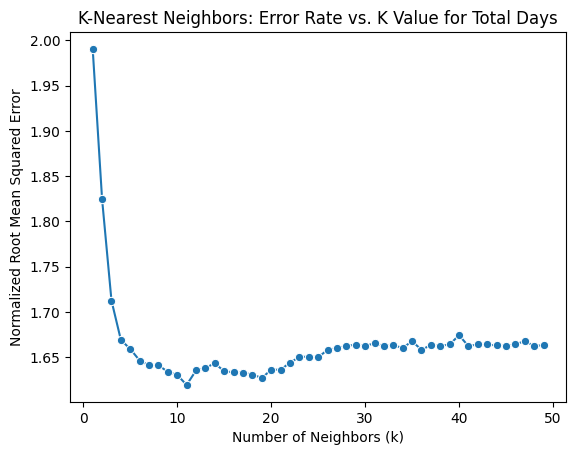

Best K:  11
Smallest Normalised Root MSE:  1.619200373379629
Mean Squared Error for  Total Days : 3568.9973172005257
Normalised Root Mean Squared Error for  Total Days : 1.619200373379629
Mean Absolute Error for  Total Days : 39.639136462665874
R-squared for  Total Days : 0.08032005439585532 



/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


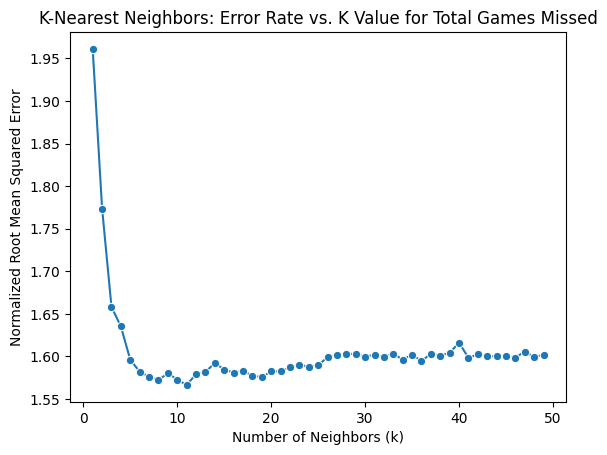

Best K:  11
Smallest Normalised Root MSE:  1.5666261399582908
Mean Squared Error for  Total Games Missed : 69.69767190622805
Normalised Root Mean Squared Error for  Total Games Missed : 1.5666261399582908
Mean Absolute Error for  Total Games Missed : 5.793424440483264
R-squared for  Total Games Missed : 0.08090519006053787 



/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


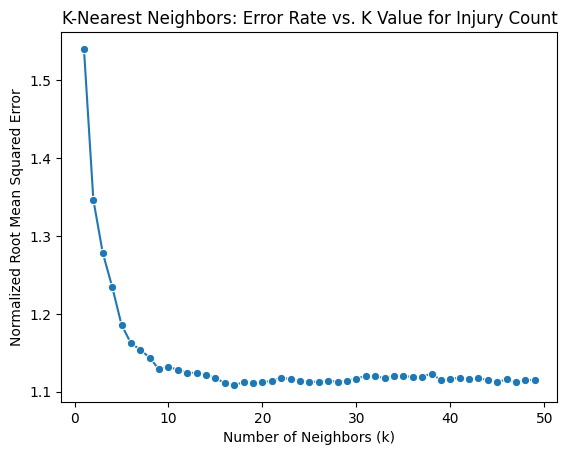

Best K:  17
Smallest Normalised Root MSE:  1.1087868700648518
Mean Squared Error for  Injury Count : 1.1869265968594283
Normalised Root Mean Squared Error for  Injury Count : 1.1087868700648518
Mean Absolute Error for  Injury Count : 0.8459566833269254
R-squared for  Injury Count : 0.11250316808887939 



/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


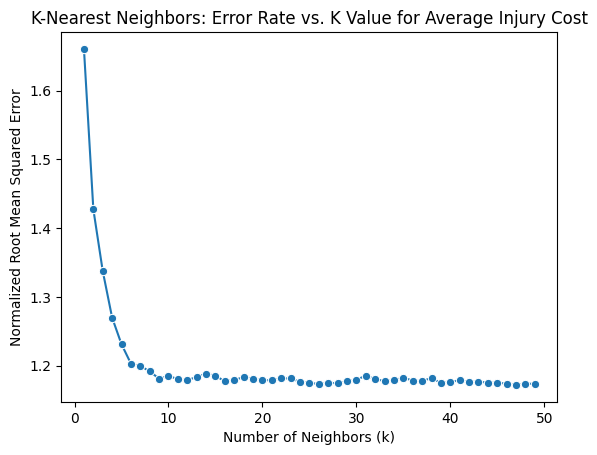

Best K:  47
Smallest Normalised Root MSE:  1.1720869867039876
Mean Squared Error for  Average Injury Cost : 0.0199048487520354
Normalised Root Mean Squared Error for  Average Injury Cost : 1.1720869867039876
Mean Absolute Error for  Average Injury Cost : 0.10886849302368702
R-squared for  Average Injury Cost : 0.07587277975297735 



/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


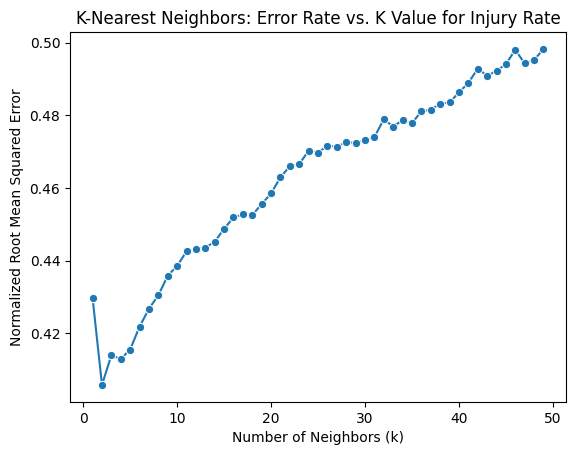

Best K:  2
Smallest Normalised Root MSE:  0.40582242264318896
Mean Squared Error for  Injury Rate : 4.794703809943039e-08
Normalised Root Mean Squared Error for  Injury Rate : 0.40582242264318896
Mean Absolute Error for  Injury Rate : 0.0001327048029095531
R-squared for  Injury Rate : 0.6062556873157394 



In [13]:
for target in targets:
    best_k, error_df = get_knn_error_rates(outfield_X_train, outfield_y_train, outfield_X_test, outfield_y_test, target)
    print("Best K: ", best_k)
    print("Smallest Normalised Root MSE: ", error_df['error'].min())
    mse, mae, nrmse, r2 = get_best_knn_error_rates(outfield_X_train, outfield_y_train, outfield_X_test, outfield_y_test, target, best_k)
    add_evaluation_metrics('KNN with best K', target, mse, mae, nrmse, r2)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


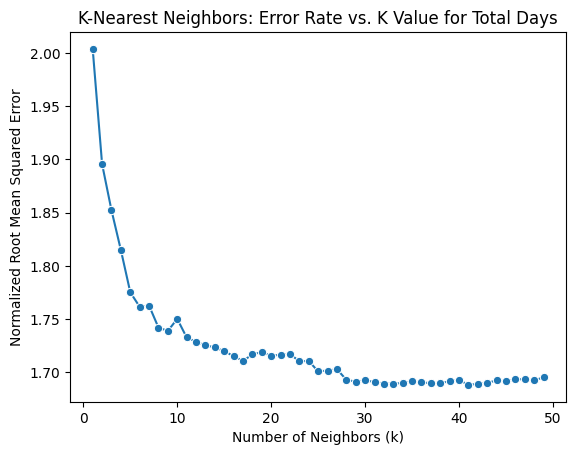

Best K:  41
Smallest Normalised Root MSE:  1.6881355564932685
Mean Squared Error for  Total Days : 3879.3562668242657
Normalised Root Mean Squared Error for  Total Days : 1.6881355564932685
Mean Absolute Error for  Total Days : 42.553642595249485
R-squared for  Total Days : 0.0003449587206337812 



/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


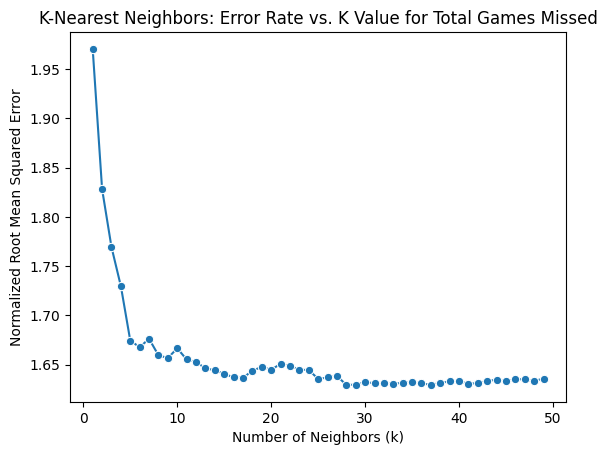

Best K:  28
Smallest Normalised Root MSE:  1.6295266259187624
Mean Squared Error for  Total Games Missed : 75.40679049397538
Normalised Root Mean Squared Error for  Total Games Missed : 1.6295266259187624
Mean Absolute Error for  Total Games Missed : 6.17662620603797
R-squared for  Total Games Missed : 0.005619730448814586 



/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


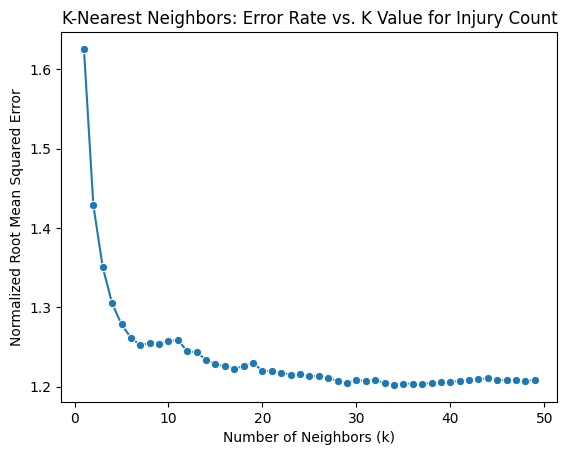

Best K:  34
Smallest Normalised Root MSE:  1.2022577339802965
Mean Squared Error for  Injury Count : 1.395477606652042
Normalised Root Mean Squared Error for  Injury Count : 1.2022577339802965
Mean Absolute Error for  Injury Count : 0.9172113289760349
R-squared for  Injury Count : -0.04343601212036696 



/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


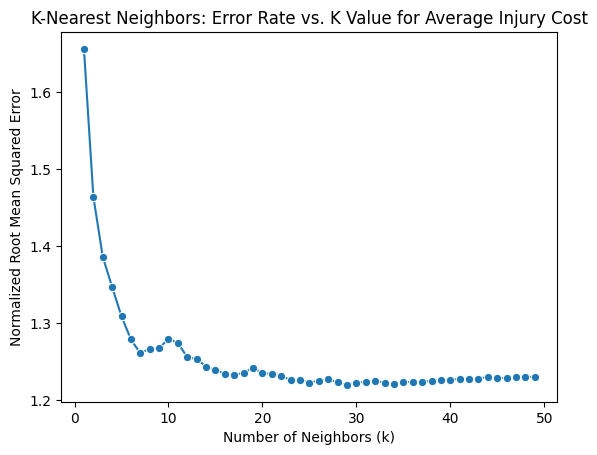

Best K:  29
Smallest Normalised Root MSE:  1.2194908028641758
Mean Squared Error for  Average Injury Cost : 0.02154746838886169
Normalised Root Mean Squared Error for  Average Injury Cost : 1.2194908028641758
Mean Absolute Error for  Average Injury Cost : 0.11562617384118398
R-squared for  Average Injury Cost : -0.0003895188363665092 



/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


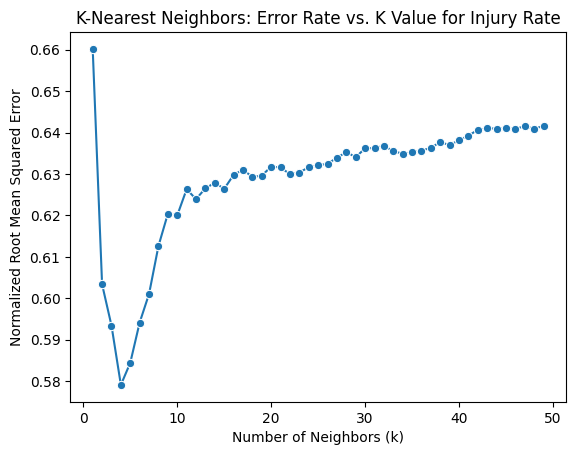

Best K:  4
Smallest Normalised Root MSE:  0.5790663631466039
Mean Squared Error for  Injury Rate : 9.762170362968266e-08
Normalised Root Mean Squared Error for  Injury Rate : 0.5790663631466039
Mean Absolute Error for  Injury Rate : 0.00023100448855155561
R-squared for  Injury Rate : 0.19832398157681774 



In [14]:
for target in targets:
    best_k, error_df = get_knn_error_rates(outfield_pca2_X_train, outfield_y_train, outfield_pca2_X_test, outfield_y_test, target)
    print("Best K: ", best_k)
    print("Smallest Normalised Root MSE: ", error_df['error'].min())
    mse, mae, nrmse, r2 = get_best_knn_error_rates(outfield_pca2_X_train, outfield_y_train, outfield_pca2_X_test, outfield_y_test, target, best_k)
    add_evaluation_metrics('KNN with best K (PCA n = 2)', target, mse, mae, nrmse, r2)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


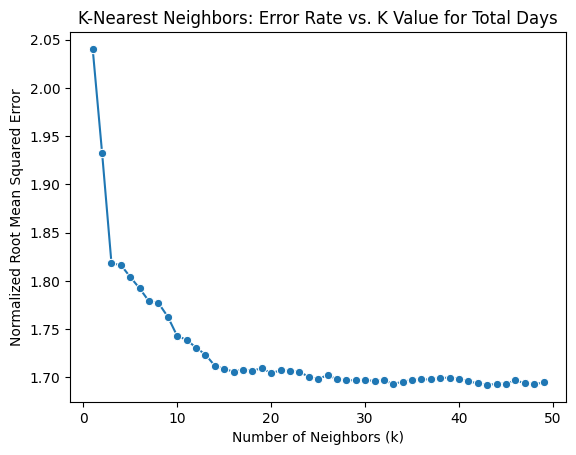

Best K:  43
Smallest Normalised Root MSE:  1.691991297626012
Mean Squared Error for  Total Days : 3897.0975855759043
Normalised Root Mean Squared Error for  Total Days : 1.691991297626012
Mean Absolute Error for  Total Days : 42.36687439833815
R-squared for  Total Days : -0.00422672727806872 



/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


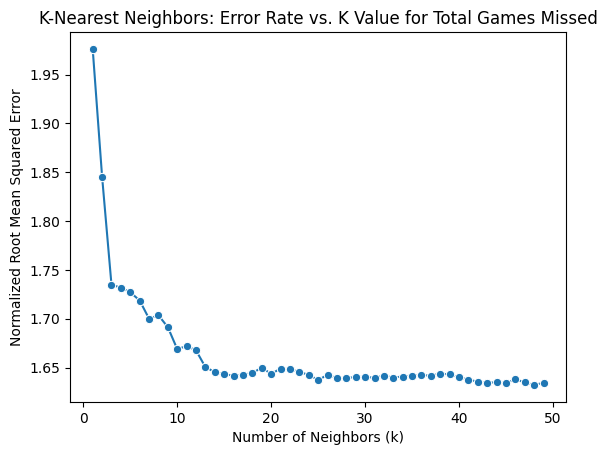

Best K:  48
Smallest Normalised Root MSE:  1.6322090155560438
Mean Squared Error for  Total Games Missed : 75.65525145243284
Normalised Root Mean Squared Error for  Total Games Missed : 1.6322090155560438
Mean Absolute Error for  Total Games Missed : 6.176742919389978
R-squared for  Total Games Missed : 0.0023433056968075183 



/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


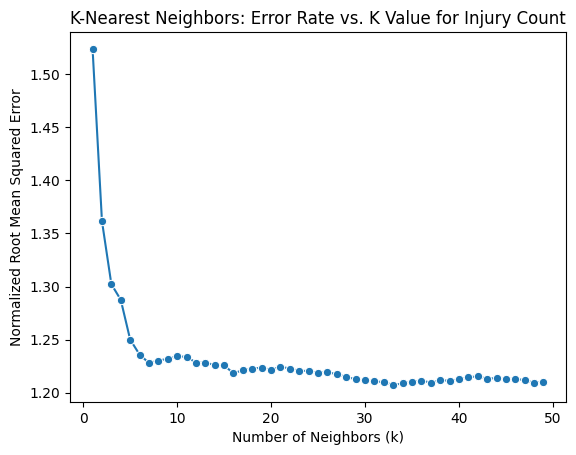

Best K:  33
Smallest Normalised Root MSE:  1.2072991142761313
Mean Squared Error for  Injury Count : 1.4072053471934638
Normalised Root Mean Squared Error for  Injury Count : 1.2072991142761313
Mean Absolute Error for  Injury Count : 0.9162870535419556
R-squared for  Injury Count : -0.0522051580840075 



/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


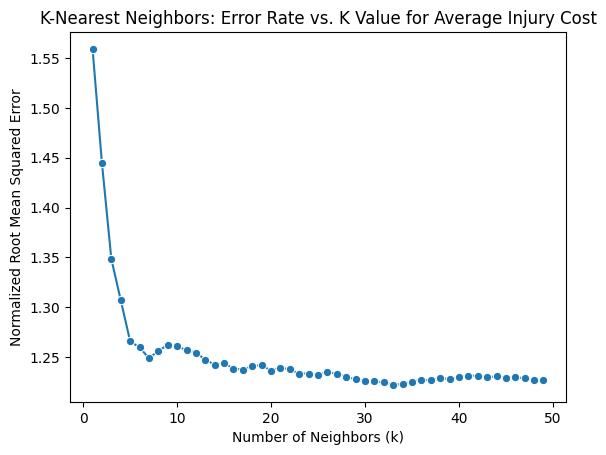

Best K:  33
Smallest Normalised Root MSE:  1.2218618647291715
Mean Squared Error for  Average Injury Cost : 0.021631339539182677
Normalised Root Mean Squared Error for  Average Injury Cost : 1.2218618647291715
Mean Absolute Error for  Average Injury Cost : 0.11551528355449925
R-squared for  Average Injury Cost : -0.004283424988109186 



/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


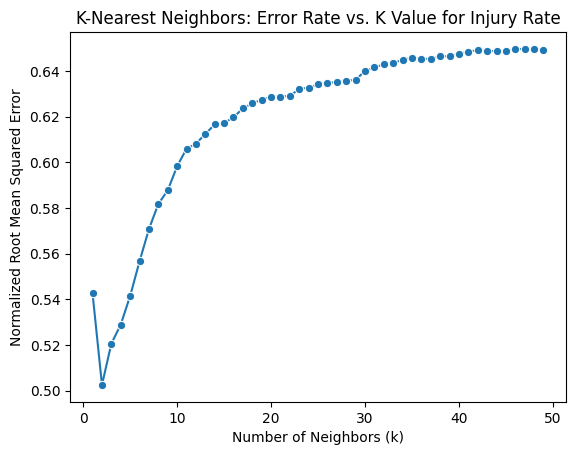

Best K:  2
Smallest Normalised Root MSE:  0.5025377677928661
Mean Squared Error for  Injury Rate : 7.352366006518584e-08
Normalised Root Mean Squared Error for  Injury Rate : 0.5025377677928661
Mean Absolute Error for  Injury Rate : 0.0001560032889197848
R-squared for  Injury Rate : 0.3962187416381465 



In [15]:
for target in targets:
    best_k, error_df = get_knn_error_rates(outfield_pca3_X_train, outfield_y_train, outfield_pca3_X_test, outfield_y_test, target)
    print("Best K: ", best_k)
    print("Smallest Normalised Root MSE: ", error_df['error'].min())
    mse, mae, nrmse, r2 = get_best_knn_error_rates(outfield_pca3_X_train, outfield_y_train, outfield_pca3_X_test, outfield_y_test, target, best_k)
    add_evaluation_metrics('KNN with best K (PCA n = 3)', target, mse, mae, nrmse, r2)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


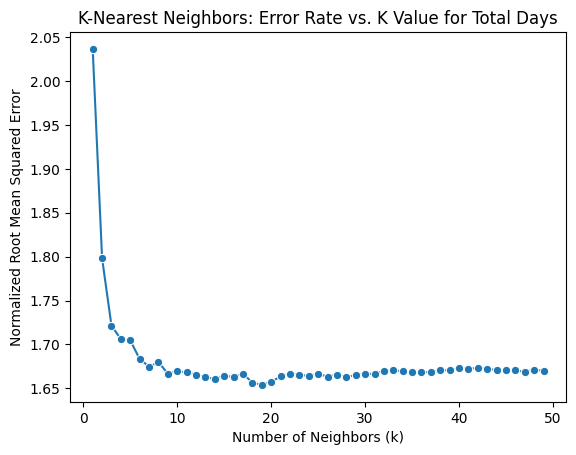

Best K:  19
Smallest Normalised Root MSE:  1.653952904151819
Mean Squared Error for  Total Days : 3723.8425397859974
Normalised Root Mean Squared Error for  Total Days : 1.653952904151819
Mean Absolute Error for  Total Days : 40.19802774911135
R-squared for  Total Days : 0.040418638612171987 



/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


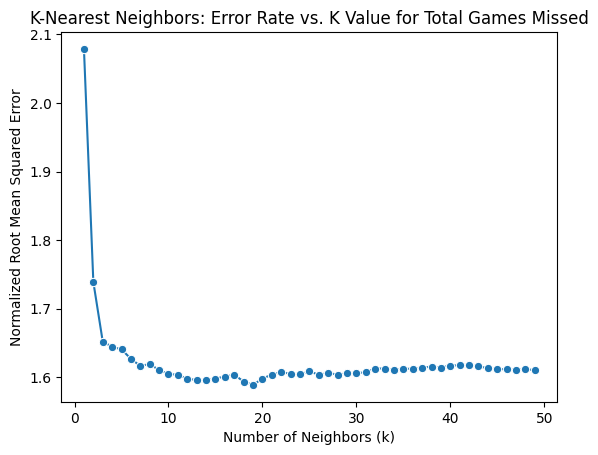

Best K:  19
Smallest Normalised Root MSE:  1.5888783071966566
Mean Squared Error for  Total Games Missed : 71.6916879401807
Normalised Root Mean Squared Error for  Total Games Missed : 1.5888783071966566
Mean Absolute Error for  Total Games Missed : 5.868019722508886
R-squared for  Total Games Missed : 0.05461034063991932 



/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


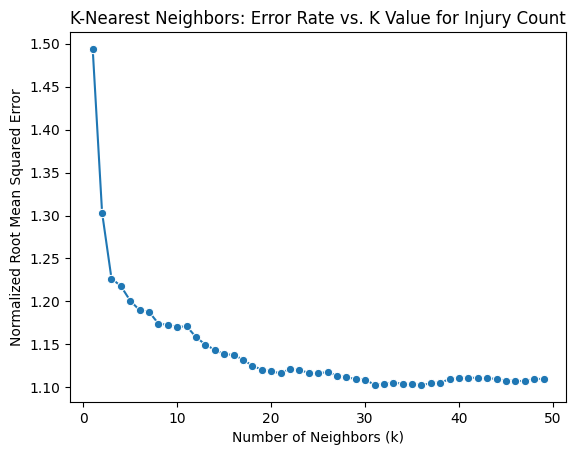

Best K:  36
Smallest Normalised Root MSE:  1.1028317527785922
Mean Squared Error for  Injury Count : 1.1742112482853226
Normalised Root Mean Squared Error for  Injury Count : 1.1028317527785922
Mean Absolute Error for  Injury Count : 0.8402323892519971
R-squared for  Injury Count : 0.12201077505128444 



/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


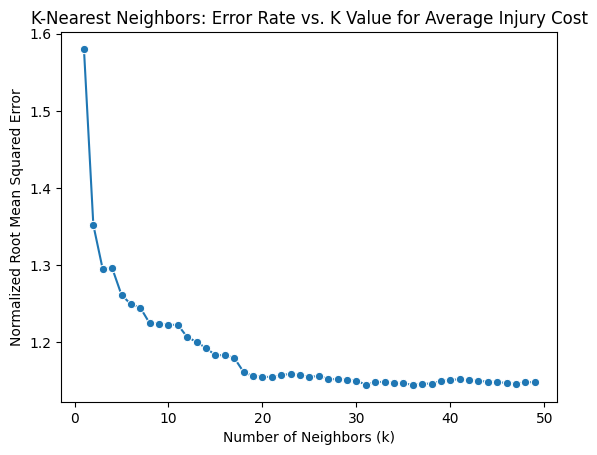

Best K:  36
Smallest Normalised Root MSE:  1.1449392017098639
Mean Squared Error for  Average Injury Cost : 0.0189934581685898
Normalised Root Mean Squared Error for  Average Injury Cost : 1.1449392017098639
Mean Absolute Error for  Average Injury Cost : 0.10733297022512708
R-squared for  Average Injury Cost : 0.11818613048129023 



/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


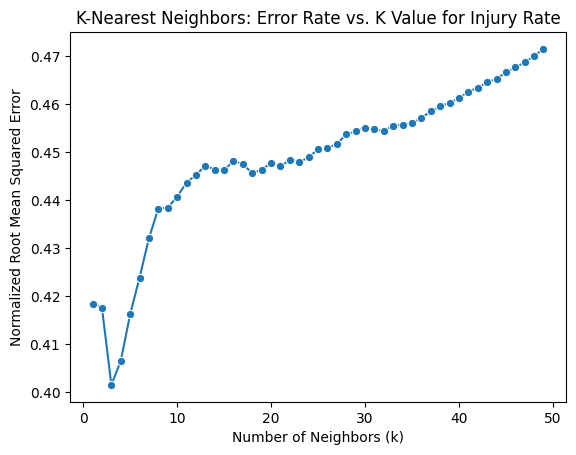

Best K:  3
Smallest Normalised Root MSE:  0.40155540699813363
Mean Squared Error for  Injury Rate : 4.6944061592316657e-08
Normalised Root Mean Squared Error for  Injury Rate : 0.40155540699813363
Mean Absolute Error for  Injury Rate : 0.00013932321489548827
R-squared for  Injury Rate : 0.6144921980802418 



In [16]:
for target in targets:
    best_k, error_df = get_knn_error_rates(outfield_pca13_X_train, outfield_y_train, outfield_pca13_X_test, outfield_y_test, target)
    print("Best K: ", best_k)
    print("Smallest Normalised Root MSE: ", error_df['error'].min())
    mse, mae, nrmse, r2 = get_best_knn_error_rates(outfield_pca13_X_train, outfield_y_train, outfield_pca13_X_test, outfield_y_test, target, best_k)
    add_evaluation_metrics('KNN with best K (PCA n = 13)', target, mse, mae, nrmse, r2)

## Decision Tree

In [17]:
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score

def get_decision_tree_error_rates(df_X, df_y, X_test, y_test, target):
    # Create a decision tree model
    dt_model = DecisionTreeRegressor()

    # Fit the model to the training data
    dt_model.fit(df_X, df_y[target])

    # Make predictions on the test set
    y_pred = dt_model.predict(X_test)

    mse = mean_squared_error(y_test[target], y_pred)
    mae = mean_absolute_error(y_test[target], y_pred)
    nrmse = normalized_root_mean_squared_error(y_test[target], y_pred)
    r2 = r2_score(y_test[target], y_pred)

    title = 'Decision Tree Errors for ' + target + ':'
    print(colored(title, 'black', attrs=['bold']))
    print("MSE:", mse)
    print("MAE:", mae)
    print("NRMSE:", nrmse)
    print("R-squared:", r2, '\n')
    
    return mse, mae, nrmse, r2

In [18]:
for target in targets:
    mse, mae, nrmse, r2 = get_decision_tree_error_rates(outfield_X_train, outfield_y_train, outfield_X_test, outfield_y_test, target)
    add_evaluation_metrics('Decision Tree', target, mse, mae, nrmse, r2)

Decision Tree Errors for Total Days:
MSE: 5569.091503267974
MAE: 45.226579520697165
NRMSE: 2.0226449820378494
R-squared: -0.43507582538825007 

Decision Tree Errors for Total Games Missed:
MSE: 110.45533769063181
MAE: 6.612200435729847
NRMSE: 1.972193788815369
R-squared: -0.4565612426503274 

Decision Tree Errors for Injury Count:
MSE: 2.0915032679738563
MAE: 1.0326797385620916
NRMSE: 1.4718563213416582
R-squared: -0.5638730559834184 

Decision Tree Errors for Average Injury Cost:
MSE: 0.03731154684095861
MAE: 0.12431372549019608
NRMSE: 1.604730216322098
R-squared: -0.7322721963273291 

Decision Tree Errors for Injury Rate:
MSE: 9.76337181310176e-14
MAE: 1.4584568062197205e-08
NRMSE: 0.0005791019954869982
R-squared: 0.9999991982253177 



In [19]:
for target in targets:
    mse, mae, nrmse, r2 = get_decision_tree_error_rates(outfield_pca2_X_train, outfield_y_train, outfield_pca2_X_test, outfield_y_test, target)
    add_evaluation_metrics('Decision Tree (PCA n = 2)', target, mse, mae, nrmse, r2)

Decision Tree Errors for Total Days:
MSE: 6388.555555555556
MAE: 49.16557734204793
NRMSE: 2.1663509926009916
R-squared: -0.6462400791130314 

Decision Tree Errors for Total Games Missed:
MSE: 118.01960784313725
MAE: 6.860566448801743
NRMSE: 2.038606086194291
R-squared: -0.5563103626424759 

Decision Tree Errors for Injury Count:
MSE: 2.8910675381263617
MAE: 1.2047930283224402
NRMSE: 1.7304747324625258
R-squared: -1.1617286930104127 

Decision Tree Errors for Average Injury Cost:
MSE: 0.0377442265795207
MAE: 0.139041394335512
NRMSE: 1.6140079460285721
R-squared: -0.7523603230463882 

Decision Tree Errors for Injury Rate:
MSE: 1.5699016080084956e-07
MAE: 0.00025230365930315184
NRMSE: 0.7343301576356521
R-squared: -0.28921379532422864 



In [20]:
for target in targets:
    mse, mae, nrmse, r2 = get_decision_tree_error_rates(outfield_pca3_X_train, outfield_y_train, outfield_pca3_X_test, outfield_y_test, target)
    add_evaluation_metrics('Decision Tree (PCA n = 3)', target, mse, mae, nrmse, r2)

Decision Tree Errors for Total Days:
MSE: 5991.501089324619
MAE: 47.25708061002179
NRMSE: 2.097950832481064
R-squared: -0.5439247794782365 

Decision Tree Errors for Total Games Missed:
MSE: 128.64488017429193
MAE: 7.080610021786493
NRMSE: 2.128396255653951
R-squared: -0.6964245499125532 

Decision Tree Errors for Injury Count:
MSE: 2.4095860566448803
MAE: 1.0849673202614378
NRMSE: 1.5798191154121555
R-squared: -0.8017120832475633 

Decision Tree Errors for Average Injury Cost:
MSE: 0.04111394335511983
MAE: 0.14276688453159042
NRMSE: 1.6845153382552693
R-squared: -0.908806977610179 

Decision Tree Errors for Injury Rate:
MSE: 1.0347514360501936e-07
MAE: 0.00016370273337416277
NRMSE: 0.5961741841132717
R-squared: 0.15025513746703112 



In [21]:
for target in targets:
    mse, mae, nrmse, r2 = get_decision_tree_error_rates(outfield_pca13_X_train, outfield_y_train, outfield_pca13_X_test, outfield_y_test, target)
    add_evaluation_metrics('Decision Tree (PCA n = 13)', target, mse, mae, nrmse, r2)

Decision Tree Errors for Total Days:
MSE: 6533.409586056645
MAE: 49.66230936819172
NRMSE: 2.1907732390814627
R-squared: -0.6835669065246806 

Decision Tree Errors for Total Games Missed:
MSE: 107.69934640522875
MAE: 6.509803921568627
NRMSE: 1.947434083678379
R-squared: -0.420218317307566 

Decision Tree Errors for Injury Count:
MSE: 1.991285403050109
MAE: 0.971677559912854
NRMSE: 1.436160238722325
R-squared: -0.4889374720508797 

Decision Tree Errors for Average Injury Cost:
MSE: 0.034397603485838785
MAE: 0.12629629629629632
NRMSE: 1.5407937074341842
R-squared: -0.5969858444303422 

Decision Tree Errors for Injury Rate:
MSE: 1.212301195014319e-08
MAE: 3.031929576986302e-05
NRMSE: 0.20406118944220278
R-squared: 0.9004450077171938 



## Random Forest

In [22]:
from sklearn.ensemble import RandomForestRegressor

def get_random_forest_error_rates(df_X, df_y, X_test, y_test, target):
    # Create a random forest model
    rf_model = RandomForestRegressor(n_estimators=100)
      # Adjust n_estimators as needed

    # Fit the model to the training data
    rf_model.fit(df_X, df_y[target])

    # Make predictions on the test set
    y_pred = rf_model.predict(X_test)
    
    mse = mean_squared_error(y_test[target], y_pred)
    mae = mean_absolute_error(y_test[target], y_pred)
    nrmse = normalized_root_mean_squared_error(y_test[target], y_pred)
    r2 = r2_score(y_test[target], y_pred)

    title = 'Random Forest Errors for ' + target + ':'
    print(colored(title, 'black', attrs=['bold']))
    print("MSE:", mse)
    print("MAE:", mae)
    print("NRMSE:", nrmse)
    print("R-squared:", r2, '\n')
    
    return mse, mae, nrmse, r2

In [23]:
for target in targets:
    mse, mae, nrmse, r2 = get_random_forest_error_rates(outfield_X_train, outfield_y_train, outfield_X_test, outfield_y_test, target)
    add_evaluation_metrics('Random Forest', target, mse, mae, nrmse, r2)

Random Forest Errors for Total Days:
MSE: 2973.0264359477123
MAE: 36.206339869281045
NRMSE: 1.4778381379597834
R-squared: 0.23389329050076946 

Random Forest Errors for Total Games Missed:
MSE: 54.740120043572986
MAE: 5.127777777777777
NRMSE: 1.3883824189431853
R-squared: 0.2781486260373164 

Random Forest Errors for Injury Count:
MSE: 1.0497579520697167
MAE: 0.7936165577342048
NRMSE: 1.042751276682736
R-squared: 0.21506784058886597 

Random Forest Errors for Average Injury Cost:
MSE: 0.018600908627450976
MAE: 0.10483747276688454
NRMSE: 1.133045845911979
R-squared: 0.1364111228327025 

Random Forest Errors for Injury Rate:
MSE: 1.6731056632541808e-11
MAE: 2.3165746676742452e-07
NRMSE: 0.0075808312925992076
R-squared: 0.9998626034338013 



In [24]:
for target in targets:
    mse, mae, nrmse, r2 = get_decision_tree_error_rates(outfield_pca2_X_train, outfield_y_train, outfield_pca2_X_test, outfield_y_test, target)
    add_evaluation_metrics('Random Forest (PCA n = 2)', target, mse, mae, nrmse, r2)

Decision Tree Errors for Total Days:
MSE: 5980.193899782135
MAE: 47.348583877995644
NRMSE: 2.0959702661783095
R-squared: -0.5410110772422472 

Decision Tree Errors for Total Games Missed:
MSE: 126.89542483660131
MAE: 7.061002178649238
NRMSE: 2.1138745732348543
R-squared: -0.6733546929558436 

Decision Tree Errors for Injury Count:
MSE: 2.867102396514161
MAE: 1.198257080610022
NRMSE: 1.723287530530367
R-squared: -1.1438093142439363 

Decision Tree Errors for Average Injury Cost:
MSE: 0.03717734204793028
MAE: 0.13721132897603486
NRMSE: 1.6018416133078228
R-squared: -0.7260414379894939 

Decision Tree Errors for Injury Rate:
MSE: 1.518452566171252e-07
MAE: 0.00024230623892667824
NRMSE: 0.7221971363919935
R-squared: -0.246963494952265 



In [25]:
for target in targets:
    mse, mae, nrmse, r2 = get_decision_tree_error_rates(outfield_pca3_X_train, outfield_y_train, outfield_pca3_X_test, outfield_y_test, target)
    add_evaluation_metrics('Random Forest (PCA n = 3)', target, mse, mae, nrmse, r2)

Decision Tree Errors for Total Days:
MSE: 5650.392156862745
MAE: 45.651416122004356
NRMSE: 2.037355329777361
R-squared: -0.45602584973129723 

Decision Tree Errors for Total Games Missed:
MSE: 127.74291938997821
MAE: 7.010893246187364
NRMSE: 2.1209217773619207
R-squared: -0.6845305016185586 

Decision Tree Errors for Injury Count:
MSE: 2.457516339869281
MAE: 1.0806100217864925
NRMSE: 1.5954542334524182
R-squared: -0.8375508407805166 

Decision Tree Errors for Average Injury Cost:
MSE: 0.0385967320261438
MAE: 0.13640522875816993
NRMSE: 1.6321334684679263
R-squared: -0.7919397993060453 

Decision Tree Errors for Injury Rate:
MSE: 1.0600473417244515e-07
MAE: 0.00016776470863658175
NRMSE: 0.603417328506976
R-squared: 0.12948196901232545 



In [26]:
for target in targets:
    mse, mae, nrmse, r2 = get_decision_tree_error_rates(outfield_pca13_X_train, outfield_y_train, outfield_pca13_X_test, outfield_y_test, target)
    add_evaluation_metrics('Random Forest (PCA n = 13)', target, mse, mae, nrmse, r2)

Decision Tree Errors for Total Days:
MSE: 5813.860566448801
MAE: 46.17864923747277
NRMSE: 2.066616014634618
R-squared: -0.4981493383961819 

Decision Tree Errors for Total Games Missed:
MSE: 114.81917211328977
MAE: 6.819172113289761
NRMSE: 2.010774821289251
R-squared: -0.5141066019084706 

Decision Tree Errors for Injury Count:
MSE: 1.962962962962963
MAE: 0.9607843137254902
NRMSE: 1.4259102679796964
R-squared: -0.46776002441777087 

Decision Tree Errors for Average Injury Cost:
MSE: 0.031777124183006544
MAE: 0.1222004357298475
NRMSE: 1.480940802189365
R-squared: -0.4753242189636533 

Decision Tree Errors for Injury Rate:
MSE: 1.1595060620321672e-08
MAE: 3.091184571250747e-05
NRMSE: 0.1995683464298638
R-squared: 0.9047805796676494 



# Comparing the performance of different models
Now that we have several models, we can compare the performance of these models by plotting a graph of Evaluation Metrics against Model, for each target that we are trying to predict.

In [27]:
eval_metrics_df = pd.DataFrame(evaluation_metrics)
eval_metrics_df.to_csv('model_performance.csv', index = False)

In [28]:
def plot_model_comparison(df, x, target):
    """
    Plots the performance of different models for a specific target variable.

    Args:
    df: DataFrame containing model performance metrics.
    target: Target variable to focus on.
    """

    # Filter data for the specified target
    target_df = df[df['Target'] == target]

    # Create a bar plot using Seaborn
    plt.figure(figsize=(8, 6))
    sns.barplot(x=x, y='Model', data=target_df, orient='h')
    plt.title(f'Model Performance by {target}')
    plt.xlabel(f'{x}')
    plt.ylabel('Model')
    plt.show()


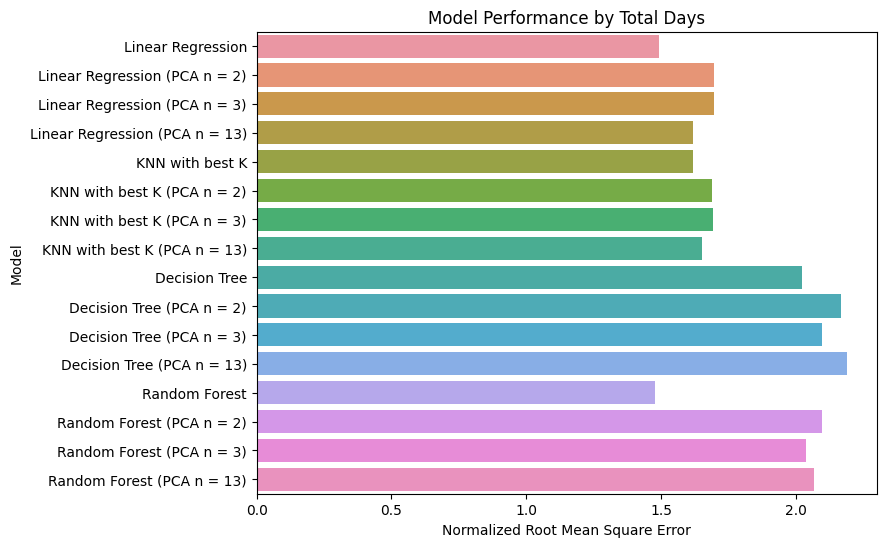

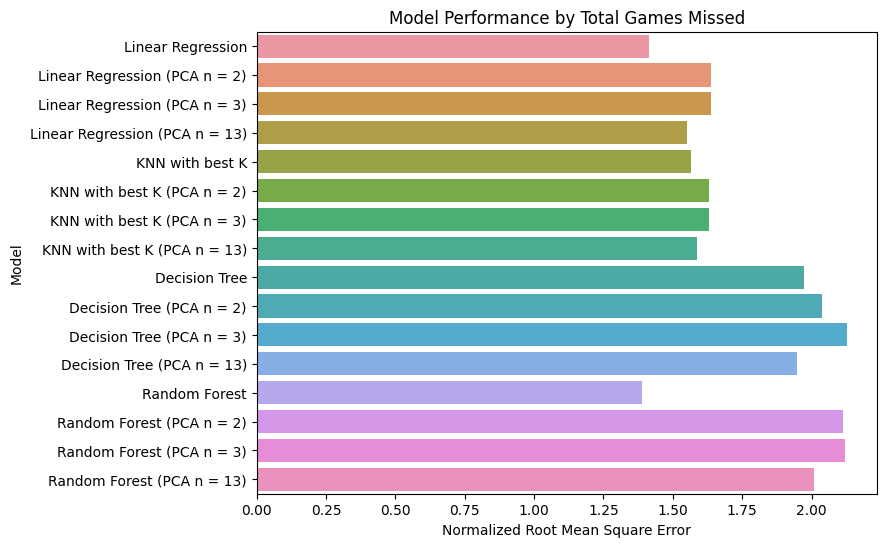

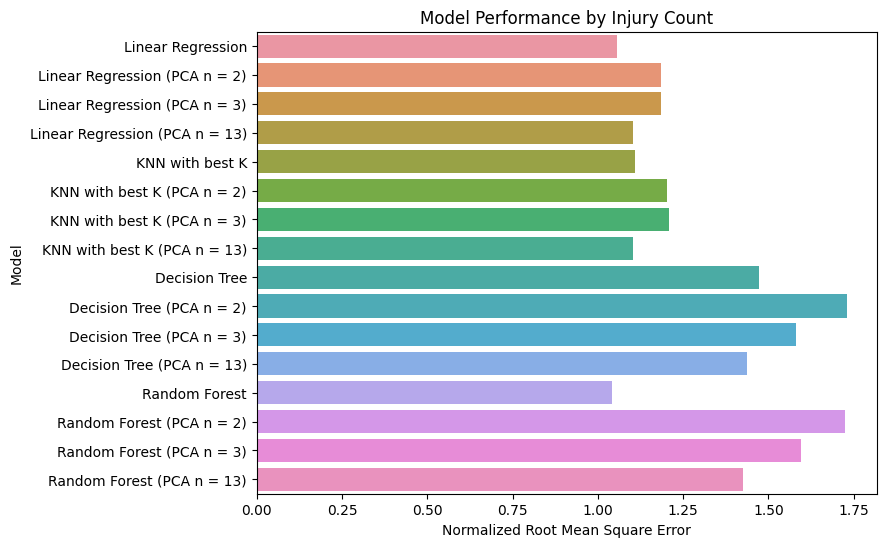

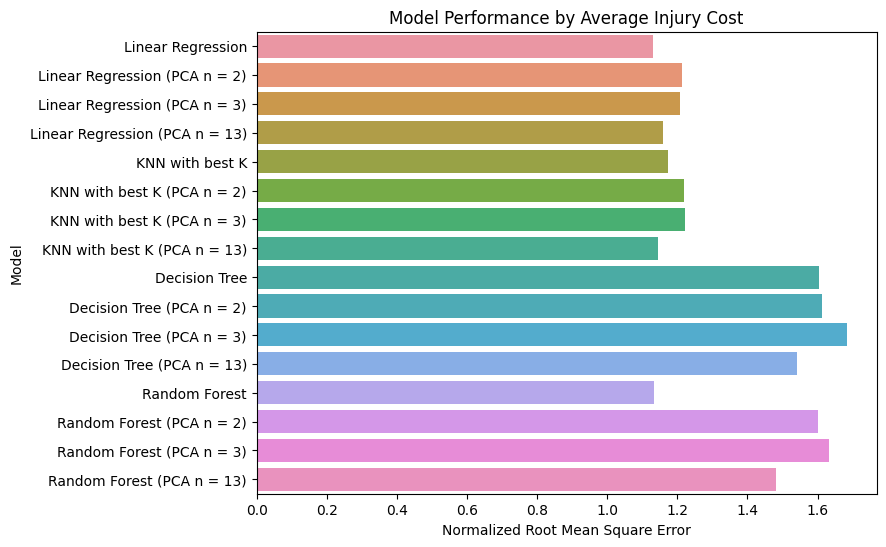

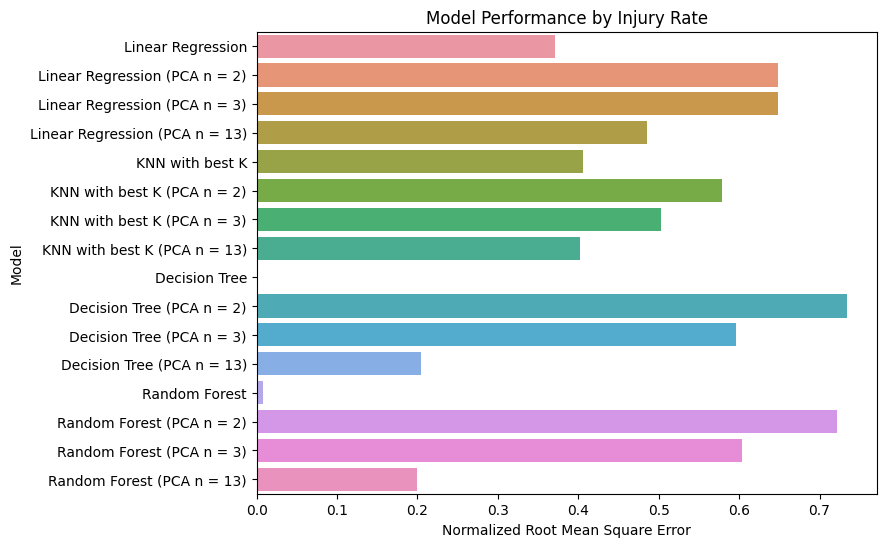

In [29]:
for target in targets:
    plot_model_comparison(eval_metrics_df, 'Normalized Root Mean Square Error', target)

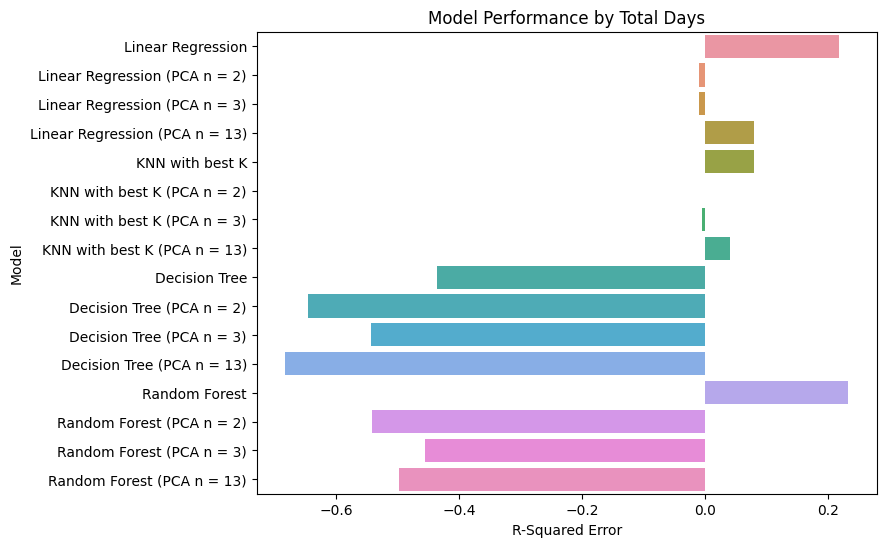

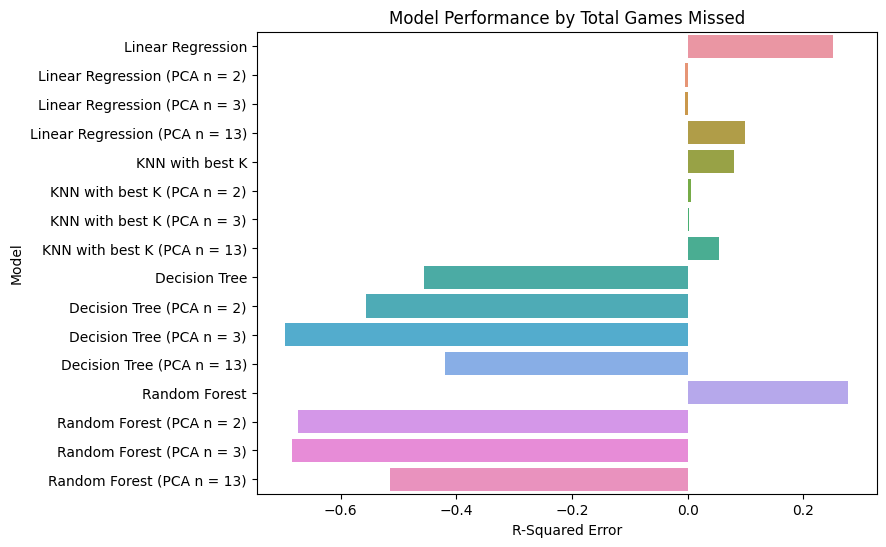

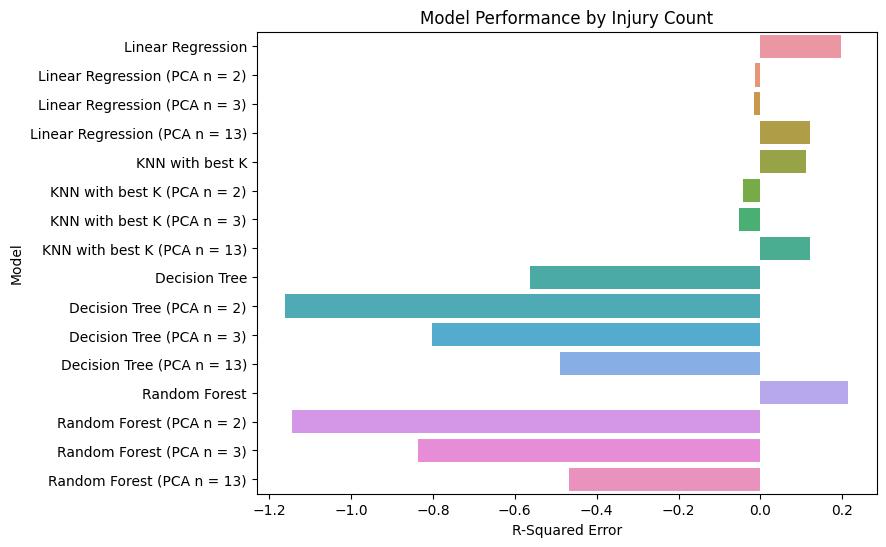

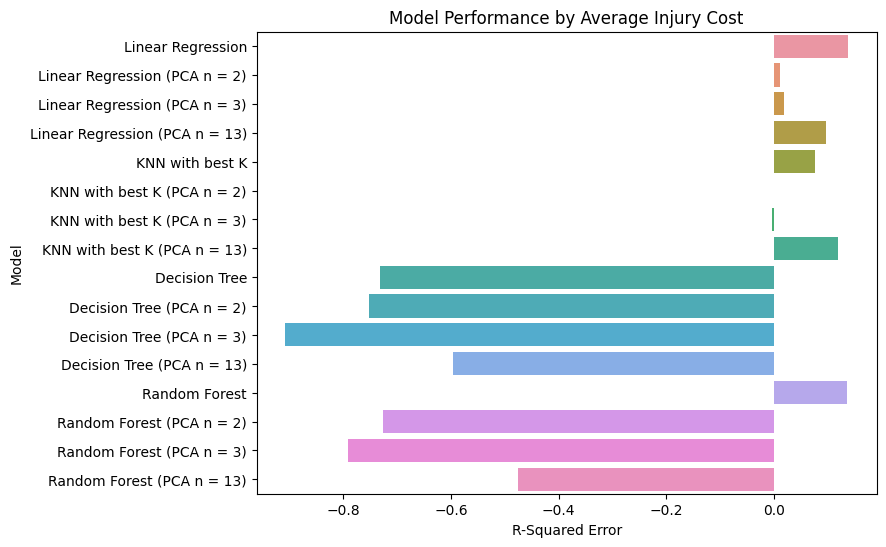

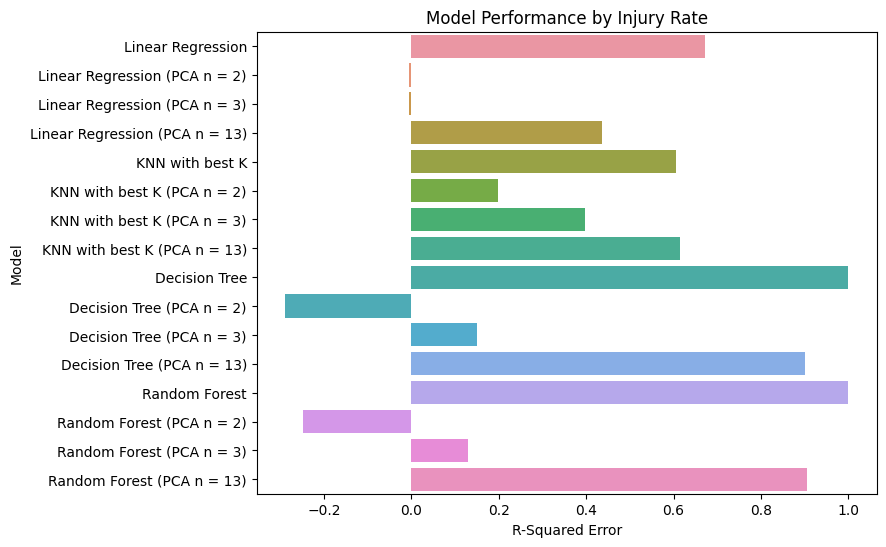

In [30]:
for target in targets:
    plot_model_comparison(eval_metrics_df, 'R-Squared Error', target)